# Preparation

## Loading Python packages

In [35]:
import polars as pl
import polars.selectors as cs
from src.single_cell import SingleCell
import seaborn as sns
import matplotlib.pyplot as plt

## Loading data

In [2]:
lr_bulk = SingleCell("results/long_read/pbid_filtered.h5ad")

In [3]:
polyALength = pl.read_parquet("proc/polyALength.parquet")

## Data Wrangling

Fill Null values with 0

In [4]:
polyALength = pl.concat([polyALength, pl.select(pl.repeat([0], polyALength.shape[0]))], how = "horizontal")\
    .with_columns(
        [pl.when(pl.col(column_name).list.first().is_null()).then(pl.col("repeat")).otherwise(pl.col(column_name)).alias(column_name) for column_name in polyALength.drop("pbid").columns]
    )\
    .drop("repeat")

Filter for rows that are contained in the fitlered count matrix

In [15]:
polyALength = polyALength\
    .filter(
        pl.col("pbid").is_in(lr_bulk.var["pbid"])
    )

## Some usage examples

### What is the relationship between mean poly(A) tail lengths and mean CPM values for a transcript?

Get mean poly(A) tail length for all transcripts

In [64]:
mean_polyA_tail_len = polyALength\
    .select(
        pl.col("pbid"),
        combined = pl.concat_list('NPC_1_1','NPC_3_1','CN_2_2','iPSC_1','iPSC_2','NPC_2_2','CN_3_2','CN_1_2','NPC_1_3','CN_3_1','NPC_2_1','CN_2_1','NPC_3_3','CN_1_3','iPSC_3')\
            .map_elements(lambda x: [i for i in x if i > 0], return_dtype = pl.List(int))
    )\
    .select(
        pl.col("pbid"),
        mean_len = pl.col("combined").list.mean()
    )

Get mean CPM values for all transcripts

In [65]:
mean_CPM = lr_bulk.CPM().to_frame()\
    .select(
        pl.col("pbid"),
        pl.mean_horizontal(cs.numeric()).alias("mean_CPM")
    )

Plotting

In [66]:
df = mean_polyA_tail_len\
    .join(
        mean_CPM, 
        on = "pbid",
        how = "left"
    )

In [67]:
df = df\
    .with_columns(
        pl.col("mean_CPM").log(base=2)
    )

Text(0, 0.5, 'log(CPM)')

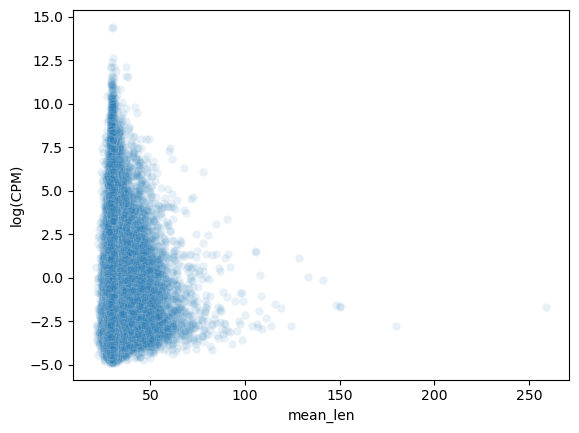

In [70]:
sns.scatterplot(df, x = "mean_len", y = "mean_CPM", alpha = 0.1)
plt.ylabel("log(CPM)")
# plt.xlim(0, 100)
# plt.ylim(0, 5500)